In [1]:
### library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from scipy.stats import norm, multivariate_normal, chi2, invwishart, truncnorm
from numpy.linalg import inv
from numpy import matmul

import statsmodels.api as sm
import statsmodels.formula.api as smf

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams['figure.facecolor'] = 'white'
np.set_printoptions(suppress=True)

c:\Users\wndus\miniconda3\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# Q2  
For a response variable $y \in \mathbb{R}^n$, design matrix $X \in \mathbb{n \times p}$, and regression coefficients $\beta \in \mathbb{R}^p$, consider a generalized linear model with likelihood of the form,  
$$\begin{aligned} p(y|X, \beta, \pi) = \text{exp} \left( \sum_{i=1}^{n} L(y_i | \eta_i, \pi)\right) \end{aligned}$$  
where $L$ is the log-likelihood function for the individual observations, $\eta_i = X_i \beta$ is the linear predictor for individual $i$ with row vector $X_i$, and $\pi$ is a dispersion parameter.

## (c) Obtain the posterior distribution

In [24]:
############################################################
# Simulated data
############################################################

np.random.seed(42)  # Set a random seed for reproducibility
p = 2  # number of variables
n = 500 
beta_true = np.array((1, 2))  # true coefficients

# Generate the design matrix X from the standard normal distribution
X = np.random.normal(0, 1, size=(n, len(beta_true)))

# Generate y
eta = matmul(X, beta_true)  # Compute the linear predictor
prob_y1 = norm.cdf(eta)  # Compute the probability of y=1 using probit model (cummulative normal distribution function)
y = np.random.binomial(1, prob_y1, size=n)  # Generate y from the Bernoulli distributio with probability prob_y1

print(f'True beta: {beta_true}')

True beta: [1 2]


In [25]:
############################################################
# Initial configuration; MLE
############################################################

# Fit the probit regression - w/o intercept
probit_model = sm.GLM(y, X, family=sm.families.Binomial(link=sm.families.links.probit()))
probit_model = probit_model.fit()

# MLE
beta_hat = probit_model.params
print(f'Beta_hat (MLE): {beta_hat}')
# print(probit_model.summary()) # Outcome of model fit

Beta_hat (MLE): [0.80022892 1.91677779]


### Normal approximation to the likelihood 
- Likelihood $p(y | X, \beta, \phi) \propto \text{N}(\beta | \hat{\beta}, V)$  
  - where $\hat{\beta}$ is MLE, $V = \left[ X' \text{diag}(-L''(y_i | \hat{\eta_i})) X \right]^{-1}$  
and $L''(y_i | \hat{\eta_i}) =  y_i \frac{(-(X_i\hat{\beta}) \phi(X_i\hat{\beta})\Phi(X_i\hat{\beta}) - \phi(X_i\hat{\beta})^2)}{\Phi(X_i\hat{\beta})^2} + (n_i - y_i) \frac{\phi(X_i\hat{\beta})^2 + (X_i\hat{\beta}) \phi(X_i\hat{\beta})(1 - \Phi(X_i\hat{\beta}))}{(1 - \Phi(X_i\hat{\beta}))^2} $  

### Normal approximation to the posterior  
- The posterior $p(\beta | \phi, y) \propto \text{N}(\beta| \hat{\beta}_{pos}, V_{pos})$  
  - where $V_{pos} = V, \hat{\beta}_{pos} = \hat{\beta}$ if $p(\beta) \propto 1$ (noninformative prior)  

In [26]:
#############################################################
# Normal approximation of likelihood and posterior          #
# beta_hat: MLE                                             #
# V (below)                                                 #
#############################################################
## 1. Likelihood - V
# Get diagonal elements
loglik_d2 = np.zeros(n)
for i in range(n):
    ni = 1
    Xi = X[i,:]
    yi = y[i]
    etai = Xi @ beta_hat  # eta_i 
    pdf = norm.pdf(etai)  # pdf of eta_i
    cdf = norm.cdf(etai)  # cdf of eta_i

    temp = yi * (-etai * pdf * cdf - pdf**2) / (cdf**2) + (ni - yi) * (pdf**2 + etai * pdf * (1 - cdf)) / ((1-cdf)**2)
    loglik_d2[i] = -temp
    
# Calculate V
V = inv(matmul(X.T, matmul(np.diag(loglik_d2), X)))
print(f'For likelihood')
print(f'beta_hat: {beta_hat}')
print(f'V: {V} ')
print('================================')

## 2. Posterior
V_pos = V.copy()
beta_hat_pos = beta_hat.copy()
print(f'For posterior')
print(f'beta_hat_pos: {beta_hat_pos}')
print(f'V_pos: {V_pos}')

For likelihood
beta_hat: [0.80022892 1.91677779]
V: [[0.10995646 0.33188601]
 [0.33188601 1.17871853]] 
For posterior
beta_hat_pos: [0.80022892 1.91677779]
V_pos: [[0.10995646 0.33188601]
 [0.33188601 1.17871853]]


### Methods to obtain posterior distribution of $\beta$

#### 1. Independent Metropolis-Hastings 
- Posterior: $p(\beta | \phi, y) \propto p(y | \beta, \phi)$
- Proposal: $J_t(\beta^{*}) \propto \text{N}(\beta^{*}| \hat{\beta}_{pos}, V_{pos})$

In [27]:
def posterior(X, y, beta):
    nu = X @ beta
    prob_y1 = norm.cdf(nu)

    return np.prod((prob_y1 ** y) * ((1 - prob_y1) ** (1-y)))

In [28]:
def independent_metropolis_hastings(X, y, beta_init, n_samples, burn_in=0):
    # initial guess
    beta = beta_init
    # for MCMC samples
    samples = np.zeros((n_samples+burn_in, len(beta_init)))
    n_accepted = 0
    
    for t in range(n_samples + burn_in):
        beta_proposal = np.random.multivariate_normal(beta_hat_pos, V_pos)  # beta = beta^(t-1)
        posterior_current = posterior(X, y, beta)
        posterior_proposal = posterior(X, y, beta_proposal)
        proposal_current = multivariate_normal.pdf(beta, beta_hat_pos, V_pos)
        proposal_proposal = multivariate_normal.pdf(beta_proposal, beta_hat_pos, V_pos)

        acceptance_ratio = (posterior_proposal * proposal_current) / (posterior_current * proposal_proposal)

        if np.random.rand() < acceptance_ratio:
            # Accept new beta
            beta = beta_proposal.copy()
            n_accepted += 1

        # Update chain
        samples[t] = beta

    return np.array(samples)[burn_in: ], n_accepted / (n_samples + burn_in)

In [29]:
# Initial guess for the optimization
beta_init = beta_hat.copy()
n_samples = 10000
burn_in = n_samples//2  # halve 

samples, acceptance_rate = independent_metropolis_hastings(X, y, beta_init, n_samples, burn_in)

print("Acceptance rate:", acceptance_rate)

Acceptance rate: 0.16446666666666668


The means of MCMC samples: [0.80692437 1.93512207] 



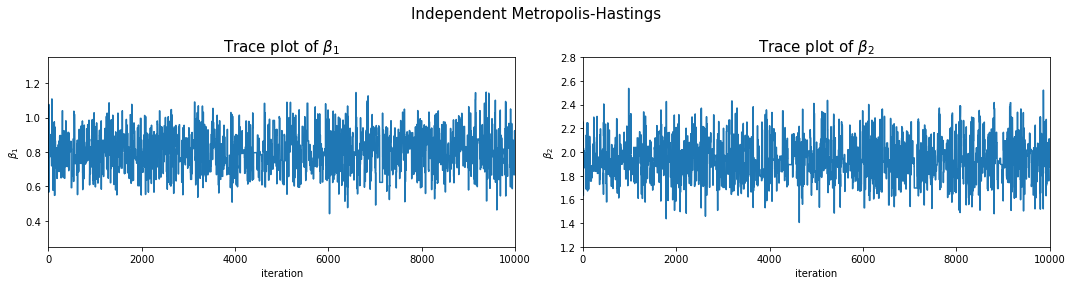

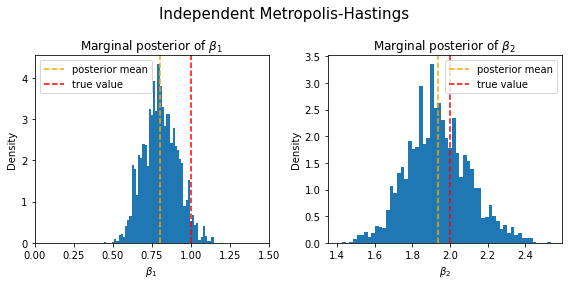

In [30]:
## MCMC Diagnostics
# 1. mean
print(f'The means of MCMC samples: {np.mean(samples, axis=0)} \n')

# 2. Trace plot
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(samples[:, 0])
plt.xlim(0, len(samples))
plt.ylim(0.25, 1.35)
plt.xlabel('iteration')
plt.ylabel(f'$\\beta_1$')
plt.title(f'Trace plot of $\\beta_1$', fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(samples[:, 1])
plt.xlim(0, len(samples))
plt.ylim(1.2, 2.8)
plt.xlabel('iteration')
plt.ylabel(f'$\\beta_2$')
plt.title(f'Trace plot of $\\beta_2$' , fontsize=15)

plt.suptitle('Independent Metropolis-Hastings', fontsize=15)
plt.tight_layout()
plt.savefig('./Q2_c_Indep_MH_trace.png')
plt.show()

# 3. Histogram
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.hist(samples[:, 0], bins='auto', density=True)
plt.axvline(np.mean(samples, axis=0)[0], color='orange', linestyle='dashed', label='posterior mean')
plt.axvline(beta_true[0], color='red', linestyle='dashed', label='true value')
plt.xlabel(f'$\\beta_1$')
plt.ylabel('Density')
plt.xlim((0,1.5))
plt.title(f'Marginal posterior of $\\beta_1$')
plt.legend()
 
plt.subplot(1, 2, 2)
plt.hist(samples[:, 1], bins='auto', density=True)
plt.axvline(np.mean(samples, axis=0)[1], color='orange', linestyle='dashed', label='posterior mean')
plt.axvline(beta_true[1], color='red', linestyle='dashed', label='true value')
plt.xlabel(f'$\\beta_2$')
plt.ylabel('Density')
plt.title(f'Marginal posterior of $\\beta_2$')
plt.legend()

plt.suptitle('Independent Metropolis-Hastings', fontsize=15)
plt.tight_layout()
plt.savefig('./Q2_c_Indep_MH_hist.png')
plt.show()

#### 2. Random walk Metropolis  
- Posterior: $p(\beta | \phi, y) \propto \text{N}(\beta| \hat{\beta}_{pos}, V_{pos})$ (normal approximation)  
- Proposal: $J_t(\beta^{*} | \beta^{t-1}) \propto \text{N}(\beta^{*}| \beta^{t-1}, (2.38^2/d)V_{pos})$ where $d=2$

In [31]:
def random_walk_metropolis(beta_init, n_samples, burn_in=0):
    # initial guess
    beta = beta_init
    # for MCMC samples
    samples = np.zeros((n_samples+burn_in, len(beta_init)))
    n_accepted = 0
    
    for t in range(n_samples + burn_in):
        beta_proposal = np.random.multivariate_normal(beta, (2.38**2/2)*V_pos)  # beta = beta^(t-1)
        likelihood_current = multivariate_normal.pdf(beta, beta_hat_pos, V_pos)
        likelihood_proposal = multivariate_normal.pdf(beta_proposal, beta_hat_pos, V_pos)

        acceptance_ratio = likelihood_proposal / likelihood_current

        if np.random.rand() < acceptance_ratio:
            # Accept new beta
            beta = beta_proposal.copy()
            n_accepted += 1

        # Update chain
        samples[t] = beta

    return np.array(samples)[burn_in: ], n_accepted / (n_samples + burn_in)

In [32]:
# Initial guess for the optimization
beta_init = beta_hat.copy()
n_samples = 10000
burn_in = n_samples//2  # halve 

samples, acceptance_rate = random_walk_metropolis(beta_init, n_samples, burn_in)

print("Acceptance rate:", acceptance_rate)

Acceptance rate: 0.3552666666666667


The means of MCMC samples: [0.79334959 1.89956601] 



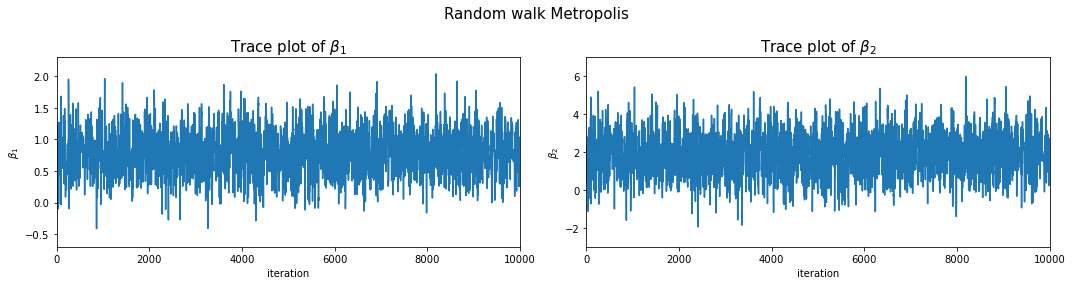

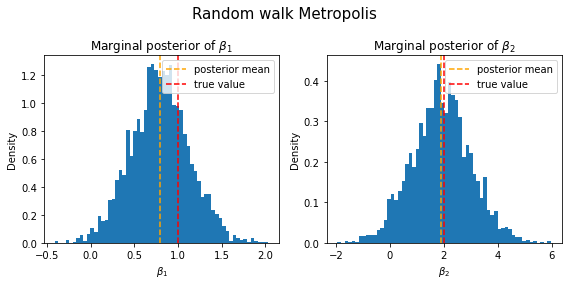

In [33]:
## MCMC Diagnostics
# 1. mean
print(f'The means of MCMC samples: {np.mean(samples, axis=0)} \n')

# 2. Trace plot
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(samples[:, 0])
plt.xlim(0, len(samples))
plt.ylim(-0.7, 2.3)
plt.xlabel('iteration')
plt.ylabel(f'$\\beta_1$')
plt.title(f'Trace plot of $\\beta_1$', fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(samples[:, 1])
plt.xlim(0, len(samples))
plt.ylim(-3, 7)
plt.xlabel('iteration')
plt.ylabel(f'$\\beta_2$')
plt.title(f'Trace plot of $\\beta_2$' , fontsize=15)

plt.suptitle('Random walk Metropolis', fontsize=15)
plt.tight_layout()
plt.savefig('./Q2_c_Randomwalk_trace.png')
plt.show()

# 3. Histogram
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.hist(samples[:, 0], bins='auto', density=True)
plt.axvline(np.mean(samples, axis=0)[0], color='orange', linestyle='dashed', label='posterior mean')
plt.axvline(beta_true[0], color='red', linestyle='dashed', label='true value')
plt.xlabel(f'$\\beta_1$')
plt.ylabel('Density')
plt.title(f'Marginal posterior of $\\beta_1$')
plt.legend()
 
plt.subplot(1, 2, 2)
plt.hist(samples[:, 1], bins='auto', density=True)
plt.axvline(np.mean(samples, axis=0)[1], color='orange', linestyle='dashed', label='posterior mean')
plt.axvline(beta_true[1], color='red', linestyle='dashed', label='true value')
plt.xlabel(f'$\\beta_2$')
plt.ylabel('Density')
plt.title(f'Marginal posterior of $\\beta_2$')
plt.legend()

plt.suptitle('Random walk Metropolis', fontsize=15)
plt.tight_layout()
plt.savefig('./Q2_c_Randomwalk_hist.png')
plt.show()

#### 3. Data augmentation
- Introduce latent variable and gibbs sampling
- Gibbs sampling: If $p(\beta) \propto 1$,  
  1. $\beta | u, y \sim N((X^{T}X)^{-1}X^{T}u, (X^{T}X)^{-1})$
  2. $u_i | \beta, y \sim$ $\begin{cases}
    \text{TN}_{(0, \inf)} (X_i \beta, 1) & y_i = 1 \\
    \text{TN}_{(-\inf, 0)} (X_i \beta, 1) & y_i = 0 \end{cases}$

In [34]:
def truncnorm_rvs(mu, sd, lower_clip, upper_clip):
    return truncnorm.rvs((lower_clip - mu) / sd, (upper_clip - mu) / sd, mu, sd)

def data_augmentation(X, y, beta_init, n_samples, burn_in=0):
    samples = np.zeros((n_samples+burn_in, 2))

    ## For initial value of u
    u = np.random.normal(X @ beta_init, 1)

    ## Gibbs sampling
    for t in range(n_samples+burn_in):
        # 1. At t-th iteration: Sampling beta^(t) given u^(t-1), y
        beta_new = np.random.multivariate_normal((inv(X.T @ X) @ X.T) @ u, inv(X.T @ X))

        # 2. At t-th iteration: Sampling u^(t) given beta^(t), y
        trunc_positive = truncnorm_rvs(mu= X @ beta_new, sd=1, lower_clip=0, upper_clip=np.inf)   # ~ TN(0, inf)
        trunc_negative = truncnorm_rvs(mu= X @ beta_new, sd=1, lower_clip=-np.inf, upper_clip=0)  # ~ TN(-inf, 0)
        # Assign values according to y
        new_u = np.zeros(len(y))
        new_u[y == 1] = trunc_positive[y == 1]
        new_u[y == 0] = trunc_negative[y == 0]

        # 3. Save as t-th samples
        samples[t] = beta_new
        u = new_u.copy()  # Update for t+1
    
    return samples[burn_in: ]

In [37]:
n_samples = 10000
burn_in = n_samples // 2  # halve 

samples = data_augmentation(X, y, beta_hat, n_samples, burn_in)  # use beta hat to initial value

The means of MCMC samples: [0.80905887 1.94398647] 



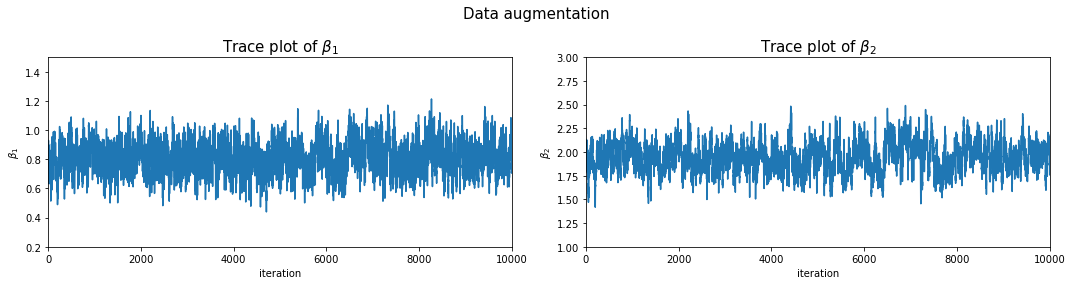

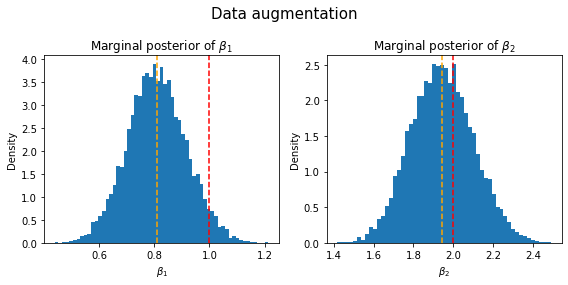

In [38]:
## MCMC Diagnostics
# 1. mean
print(f'The means of MCMC samples: {np.mean(samples, axis=0)} \n')

# 2. Trace plot
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(samples[:, 0])
plt.xlim(0, len(samples))
plt.ylim((0.2, 1.5))
plt.xlabel('iteration')
plt.ylabel(f'$\\beta_1$')
plt.title(f'Trace plot of $\\beta_1$', fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(samples[:, 1])
plt.xlim(0, len(samples))
plt.ylim((1, 3))
plt.xlabel('iteration')
plt.ylabel(f'$\\beta_2$')
plt.title(f'Trace plot of $\\beta_2$', fontsize=15)

plt.suptitle('Data augmentation', fontsize=15)
plt.tight_layout()
plt.savefig('./Q2_c_DataAugumentation_traceplot.png')
plt.show()

# 3. Histogram
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.hist(samples[:, 0], bins='auto', density=True)
plt.axvline(np.mean(samples, axis=0)[0], color='orange', linestyle='dashed', label='posterior mean')
plt.axvline(beta_true[0], color='red', linestyle='dashed', label='true value')
plt.xlabel(f'$\\beta_1$')
plt.ylabel('Density')
plt.title(f'Marginal posterior of $\\beta_1$')
 
plt.subplot(1, 2, 2)
plt.hist(samples[:, 1], bins='auto', density=True)
plt.axvline(np.mean(samples, axis=0)[1], color='orange', linestyle='dashed', label='posterior mean')
plt.axvline(beta_true[1], color='red', linestyle='dashed', label='true value')
plt.xlabel(f'$\\beta_2$')
plt.ylabel('Density')
plt.title(f'Marginal posterior of $\\beta_2$')

plt.suptitle('Data augmentation', fontsize=15)
plt.tight_layout()
plt.savefig('./Q2_c_DataAugumentation_hist.png')
plt.show()